# normal_model

## time pyd_data

In [ ]:
# ================== 1️⃣ 导入路径与函数 ==================
%run ../_init_path.py

import os
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import subgraph, add_self_loops

# === 导入模型结构 ===
from models import GraphContrastiveLearner, augment_graph, summarize_graph


# ===================== 0️⃣ 路径设置 =====================
train_graph_path = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/all_class/train/pyg/train_graph_with_labelmask.pt"
val_graph_path   = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/all_class/val/pyg/graph.pt"
test_graph_path  = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/all_class/test/pyg/graph.pt"

save_dir = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model_opt/model_save/time"
os.makedirs(save_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ===================== 1️⃣ 加载图数据 =====================
print("\n========== 加载 train 图（带 label mask） ==========")
train_data = torch.load(train_graph_path)
summarize_graph(train_data)

print("\n========== 加载 val 图 ==========")
val_data = torch.load(val_graph_path)

print("\n========== 加载 test 图 ==========")
test_data = torch.load(test_graph_path)


# ===================== 2️⃣ 对 train_data.x 做 Z-score 标准化 =====================
x_mean = train_data.x.mean(dim=0, keepdim=True)
x_std  = train_data.x.std(dim=0, keepdim=True) + 1e-6
train_data.x = (train_data.x - x_mean) / x_std

print("🎯 已完成 train_data.x 标准化")


# ===================== 3️⃣ 构造 batch 子图 =====================
batch_size = 1024
num_nodes = train_data.num_nodes

perm = torch.randperm(num_nodes)

batches = []
for i in range(0, num_nodes, batch_size):
    node_idx = perm[i:i + batch_size]

    # ---- 提取子图（必须 CPU）----
    sub_edge_index, _ = subgraph(
        node_idx,
        train_data.edge_index,
        relabel_nodes=True
    )

    sub_x = train_data.x[node_idx]

    # ---------- ⭐ 加入自环 ----------
    sub_edge_index, _ = add_self_loops(
        sub_edge_index, num_nodes=sub_x.size(0)
    )

    sub_data = Data(
        x=sub_x,
        edge_index=sub_edge_index,
    )
    batches.append(sub_data)

print(f"📌 共生成 {len(batches)} 个子图 batch")

loader = DataLoader(batches, batch_size=1, shuffle=True)


# ===================== 4️⃣ 初始化模型 =====================
in_dim = train_data.x.size(1)
hidden_dim = 256
out_dim = 256
proj_dim = 128
tau = 0.5

model = GraphContrastiveLearner(in_dim, hidden_dim, out_dim, proj_dim, tau).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
# ===================== 5️⃣ Batch 训练 =====================
epochs = 200

best_loss = float("inf")
best_model_path = os.path.join(save_dir, f"KAIST_normal_pretrain_best.pt")

print("\n================= 🚀 开始 Batch 对比学习训练 =================\n")

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0.0

    for batch_data in loader:
        batch_data = batch_data[0].to(device)   # batch_size=1 → 取第 0 个

        # ---- 生成两份增强视图 ----
        data1 = augment_graph(
            batch_data,
            feature_drop_prob=0.2,
            edge_drop_prob=0.1,
            noise_std=0.02
        ).to(device)

        data2 = augment_graph(
            batch_data,
            feature_drop_prob=0.2,
            edge_drop_prob=0.1,
            noise_std=0.02
        ).to(device)

        # ---- 计算 InfoNCE 对比损失 ----
        loss = model.compute_loss(
            data1.x, data1.edge_index,
            data2.x, data2.edge_index
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # ======== 日志输出 ========
    if epoch % 10 == 0:
        print(f"Epoch [{epoch:03d}/{epochs}] | InfoNCE Loss: {total_loss:.4f}")

    # ======== 保存当前最优模型 ========
    if total_loss < best_loss:
        best_loss = total_loss

        torch.save({
            "model_state_dict": model.state_dict(),
            "best_loss": best_loss,
            "epoch": epoch,
            "config": {
                "in_dim": in_dim,
                "hidden_dim": hidden_dim,
                "out_dim": out_dim,
                "proj_dim": proj_dim,
                "tau": tau
            }
        }, best_model_path)

        print(f"💾 [BEST MODEL UPDATED] Epoch {epoch} | Loss={total_loss:.4f}")


# ===================== 最终模型保存 =====================
final_path = os.path.join(save_dir, f"KAIST_normal_pretrain_epoch{epochs}.pt")
torch.save({
    "model_state_dict": model.state_dict(),
    "epoch": epochs,
    "config": {
        "in_dim": in_dim,
        "hidden_dim": hidden_dim,
        "out_dim": out_dim,
        "proj_dim": proj_dim,
        "tau": tau
    }
}, final_path)

print(f"\n🏁 最终模型已保存至: {final_path}")
print(f"🏆 最优模型已保存至: {best_model_path} | best_loss={best_loss:.4f}")


## 效果可视化

/tmp/ipykernel_764138/719304330.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


✅ 使用训练时的原始模型读取成功！不会报错
⭐ Train Embeddings Shape: (42000, 128)
⭐ Test  Embeddings Shape: (14000, 128)


/home/charles/miniconda3/envs/d2l/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/charles/miniconda3/envs/d2l/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


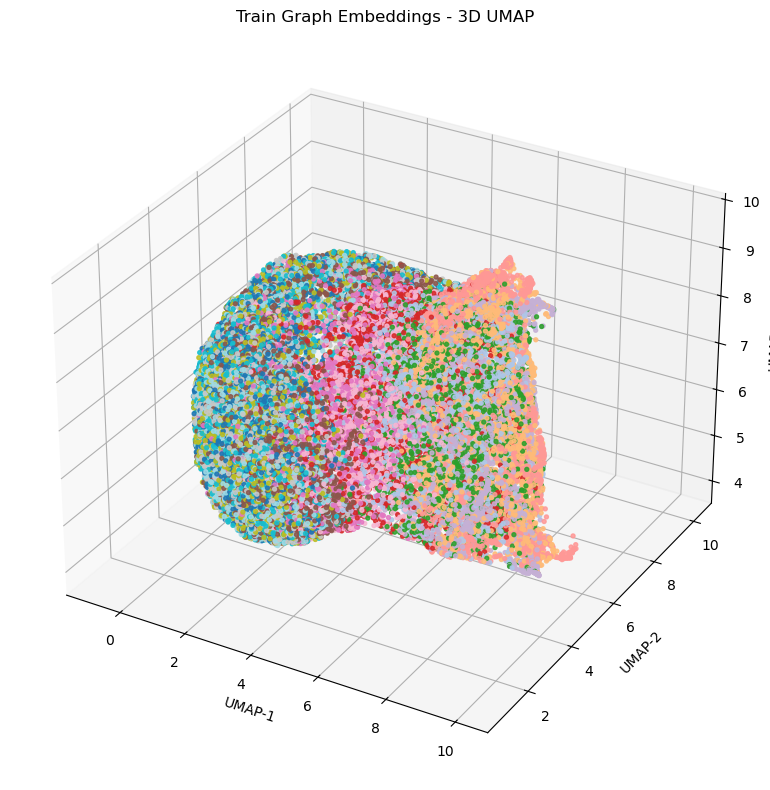

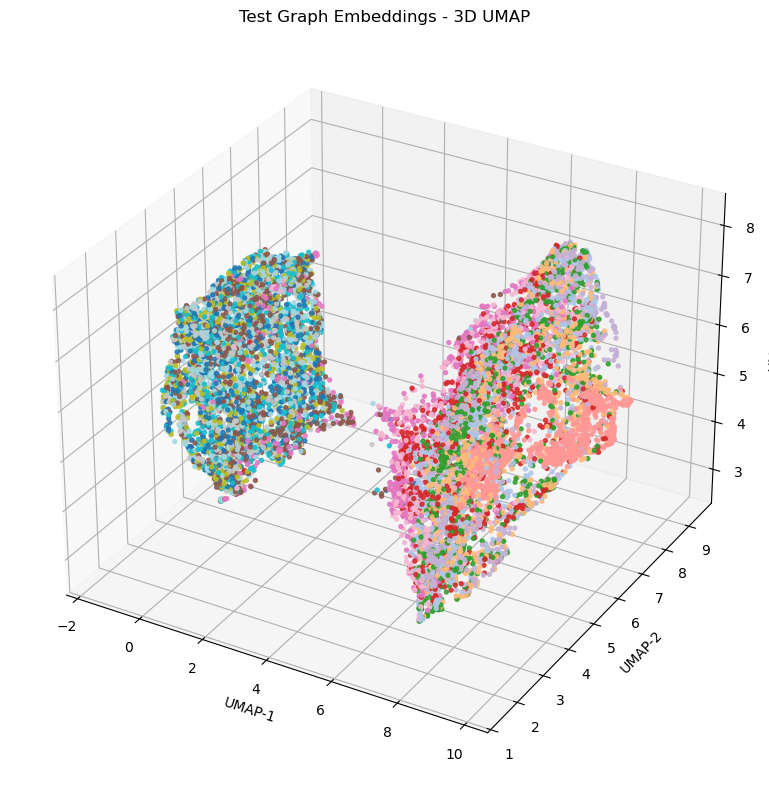


🎯 Train / Test 3D UMAP 全部完成并保存！


In [4]:
# ======================================================================
#                ⭐ 单 Cell：不会报错的模型加载 + Train/Test 3D 可视化 ⭐
# ======================================================================

# ====================== 环境导入 ======================
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import umap
from mpl_toolkits.mplot3d import Axes3D

# ====================== 路径 ======================
save_dir = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model_opt/result/time"
os.makedirs(save_dir, exist_ok=True)

model_path = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model_opt/model_save/time/KAIST_normal_pretrain_best.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====================== 加载训练时的真实模型结构 ======================
from models import GraphContrastiveLearner   # 用你确认的“不会报错”的版本

# ----- 加载 checkpoint -----
checkpoint = torch.load(model_path, map_location=device)
cfg = checkpoint["config"]

# ----- 按训练时的方式实例化模型（不会报错 👍）-----
model = GraphContrastiveLearner(
    in_dim     = cfg["in_dim"],
    hidden_dim = cfg["hidden_dim"],
    out_dim    = cfg["out_dim"],
    proj_dim   = cfg["proj_dim"],
    tau        = cfg["tau"] if "tau" in cfg else 0.5
).to(device)

# ----- 加载权重（不会报错 👍）-----
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("✅ 使用训练时的原始模型读取成功！不会报错")

# ======================================================================
#                ⭐ 1️⃣ 提取 Train 和 Test 的嵌入
# ======================================================================

# 你前面已经：train_data / test_data = torch.load(...)
train_data = train_data.to(device)
test_data  = test_data.to(device)

with torch.no_grad():
    _, z_train = model(train_data.x, train_data.edge_index)
    _, z_test  = model(test_data.x,  test_data.edge_index)

train_emb = z_train.cpu().numpy()
test_emb  = z_test.cpu().numpy()

train_labels = train_data.y.cpu().numpy() if hasattr(train_data, "y") else np.zeros(train_emb.shape[0])
test_labels  = test_data.y.cpu().numpy() if hasattr(test_data,  "y") else np.zeros(test_emb.shape[0])

print(f"⭐ Train Embeddings Shape: {train_emb.shape}")
print(f"⭐ Test  Embeddings Shape: {test_emb.shape}")

# ======================================================================
#                ⭐ 2️⃣ 3D UMAP 降维
# ======================================================================
reducer_train = umap.UMAP(
    n_neighbors=10, min_dist=0.1, n_components=3,
    metric="cosine", random_state=42
)
train_umap = reducer_train.fit_transform(train_emb)

reducer_test = umap.UMAP(
    n_neighbors=10, min_dist=0.1, n_components=3,
    metric="cosine", random_state=42
)
test_umap = reducer_test.fit_transform(test_emb)

# ======================================================================
#                ⭐ 3️⃣ 绘制 Train 3D UMAP
# ======================================================================
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(
    train_umap[:,0], train_umap[:,1], train_umap[:,2],
    c=train_labels, cmap='tab20', s=8, alpha=0.85
)

ax.set_title("Train Graph Embeddings - 3D UMAP")
ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2"); ax.set_zlabel("UMAP-3")

legend = plt.legend(
    *scatter.legend_elements(num=None),
    title="Labels", loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=8
)
ax.add_artist(legend)

plt.tight_layout(rect=[0,0,0.85,1])
plt.savefig(os.path.join(save_dir, "train_umap_3d.png"), dpi=300)
plt.show()

# ======================================================================
#                ⭐ 4️⃣ 绘制 Test 3D UMAP
# ======================================================================
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(
    test_umap[:,0], test_umap[:,1], test_umap[:,2],
    c=test_labels, cmap='tab20', s=8, alpha=0.85
)

ax.set_title("Test Graph Embeddings - 3D UMAP")
ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2"); ax.set_zlabel("UMAP-3")

legend = plt.legend(
    *scatter.legend_elements(num=None),
    title="Labels", loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=8
)
ax.add_artist(legend)

plt.tight_layout(rect=[0,0,0.85,1])
plt.savefig(os.path.join(save_dir, "test_umap_3d.png"), dpi=300)
plt.show()

# ======================================================================
#                ⭐ 5️⃣ 保存嵌入
# ======================================================================
np.save(os.path.join(save_dir, "train_emb.npy"), train_emb)
np.save(os.path.join(save_dir, "train_umap_3d.npy"), train_umap)
np.save(os.path.join(save_dir, "test_emb.npy"),  test_emb)
np.save(os.path.join(save_dir, "test_umap_3d.npy"),  test_umap)

print("\n🎯 Train / Test 3D UMAP 全部完成并保存！")
